کد مربوط به مقاله ارسالی درخصوص تبدیل لایه‌های طبقه‌بند تمام متصل به پیچشی

M. Amintoosi

In [1]:
import keras
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
# This is module with image preprocessing utilities
from keras.preprocessing import image
from keras.layers import BatchNormalization
import tensorflow as tf
from keras.callbacks import ModelCheckpoint
keras.__version__

'2.8.0'

In [2]:
import os, shutil
from os import listdir
from os.path import isfile, join
from pathlib import Path
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import math
import seaborn as sns
from skimage.transform import resize

tf.random.set_seed(3)

In [3]:
!pip install python-bidi
!pip install arabic-reshaper
!pip install pycm
from pycm import *

     |████████████████████████████████| 66 kB 4.2 MB/s 
     |████████████████████████████████| 583 kB 26.9 MB/s 


In [4]:
from bidi.algorithm import get_display
import arabic_reshaper

In [5]:
def make_farsi_text(x):
    reshaped_text = arabic_reshaper.reshape(x)
    farsi_text = get_display(reshaped_text)
    return farsi_text

In [6]:
!git clone https://github.com/mamintoosi/FC2FC.git
%cd FC2FC
import FC2FC

Cloning into 'FC2FC'...
remote: Enumerating objects: 4089, done.
remote: Counting objects: 100% (4089/4089), done.
remote: Compressing objects: 100% (4039/4039), done.
remote: Total 4089 (delta 90), reused 4039 (delta 44), pack-reused 0
Receiving objects: 100% (4089/4089), 64.36 MiB | 3.18 MiB/s, done.
Resolving deltas: 100% (90/90), done.
Checking out files: 100% (3916/3916), done.
/content/FC2FC


In [7]:
data_dir = 'data/Calligraphy/'
models_dir = 'models/'

train_dir = os.path.join(data_dir, 'train')
validation_dir = os.path.join(data_dir, 'val')
test_dir = os.path.join(data_dir, 'test')

train_shekasteh_dir = os.path.join(train_dir, 'shekasteh')
train_suls_dir = os.path.join(train_dir, 'suls')
validation_shekasteh_dir = os.path.join(validation_dir, 'shekasteh')
validation_suls_dir = os.path.join(validation_dir, 'suls')
test_shekasteh_dir = os.path.join(test_dir, 'shekasteh')
test_suls_dir = os.path.join(test_dir, 'suls')

inputImSize = 150

In [8]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                    rotation_range=45,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    # shear_range=0.2,
                                    zoom_range=0.2,
                                    # horizontal_flip=True,
                                    # vertical_flip=True
                                   )
test_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(inputImSize, inputImSize),
        batch_size=32,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(inputImSize, inputImSize),
        batch_size=16,
        class_mode='binary')
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(inputImSize, inputImSize),
        batch_size=1,
        class_mode='binary')
        

Found 568 images belonging to 2 classes.
Found 70 images belonging to 2 classes.
Found 72 images belonging to 2 classes.


In [9]:
mdl = 'models/best_model.h5'
checkpoint = ModelCheckpoint(filepath=mdl, 
                             monitor='val_loss',
                             verbose=0, 
                             save_best_only=True,
                             mode='min')
callbacks = [checkpoint]

In [10]:
model = FC2FC.seq_model(inputImSize)

In [11]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(), 
              metrics=['acc'])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv1 (Conv2D)              (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 Conv2 (Conv2D)              (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 Conv3 (Conv2D)              (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

In [13]:
%%time
epochs = 100
history = model.fit_generator(
          train_generator,
          epochs=epochs,
          validation_data=validation_generator,
          callbacks=callbacks,
          verbose = 0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


CPU times: user 8min 21s, sys: 10.9 s, total: 8min 31s
Wall time: 7min 16s


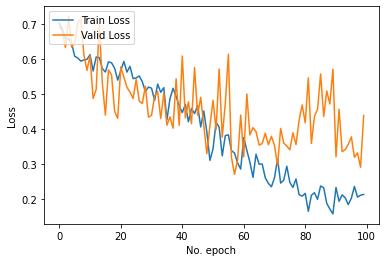

In [14]:
# Plot history: MAE
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Valid Loss')
# plt.title('MAE')
plt.ylabel('Loss')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [15]:
!ls -hs models

total 20M
20M best_model.h5


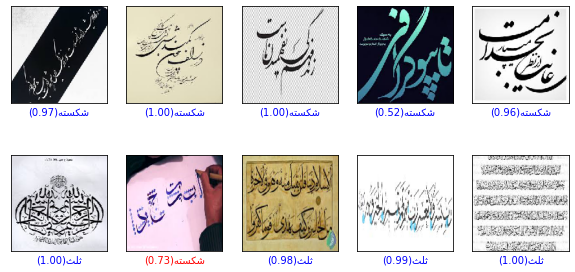

In [35]:
# تست مدل اولیه 
class_names = ['شکسته', 'ثلث']
plt.figure(figsize=(10,5))
sulsCounter = 0 
shekastehCounter = 0
count = np.zeros(2)
for i in range(100):
    x,y = next(test_generator)
    true_label = int(y[0])
    if count[true_label]>=5:
        continue
    count[true_label]+=1
    yHat = model.predict(x)
    # plt.figure(i)
    # imgplot = plt.imshow(x[0])
    # print(y,yHat)
    plt.subplot(2,5,5*true_label+count[true_label])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x[0])#, cmap=plt.cm.binary)
    # plt.imshow(xOrigSize[0])#, cmap=plt.cm.binary)
    # predicted_label = np.argmax(predictions_array)
    predicted_label = int(round(yHat[0][0]))
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'
    prob = yHat[0][0] if predicted_label==1 else (1-yHat[0][0])
    plt.xlabel("({:.2f}){}".format(prob,make_farsi_text(class_names[predicted_label])),color=color, fontsize=10)
plt.show()

In [36]:
num_of_test_samples = len(os.listdir(test_shekasteh_dir)) + len(os.listdir(test_suls_dir))

true_labels = np.zeros((num_of_test_samples,),dtype=int) 
predicted_labels = np.zeros((num_of_test_samples,),dtype=int)
for i in range(num_of_test_samples):
    x,y = next(test_generator)
    yHat = model.predict(x)
    true_labels[i] = int(y[0])
    predicted_labels[i] = int(round(yHat[0][0]))

# print(confusion_matrix(true_labels, predicted_labels))
# print(classification_report(true_labels, predicted_labels, target_names=class_names))

ACC=0.92
0:0.92	1:0.92
FNR:0.08, FPR:0.08
TNR:0.92, TPR:0.92
F1:0.92


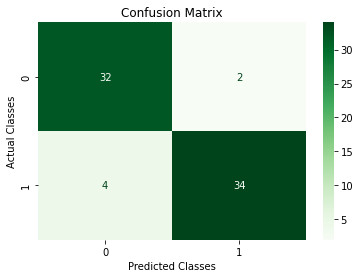

In [37]:
cm = ConfusionMatrix(actual_vector=true_labels, predict_vector=predicted_labels) # Create CM From Data
cm.plot(cmap=plt.cm.Greens,normalized=False,number_label=True,plot_lib="seaborn")
# print(cm)
print('ACC={:.2f}'.format(cm.Overall_ACC))
print("\t".join("{}:{:.2f}".format(k, v) for k, v in cm.AUC.items()))
print('FNR:{:.2f}, FPR:{:.2f}'.format(cm.FNR_Macro, cm.FPR_Macro))
print('TNR:{:.2f}, TPR:{:.2f}'.format(cm.TNR_Macro, cm.TPR_Macro))
print('F1:{:.2f}'.format(cm.F1_Macro))    


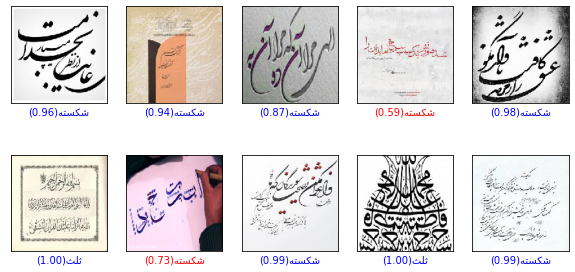

In [38]:
# تست مدل تمام پیچشی شده
plt.figure(figsize=(10,5))
for i in range(10):
    x,y = next(test_generator)
    convModel = FC2FC.convert_model(model,mdl,[inputImSize,inputImSize])
    yHat = convModel.predict(x)
    # plt.figure(i)
    # imgplot = plt.imshow(x[0])
    # print(y,yHat)
    plt.subplot(2,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x[0])#, cmap=plt.cm.binary)
    # predicted_label = np.argmax(predictions_array)
    true_label = int(y[0])
    # ConvModel Last Layer is different from denseModel Last Layer
    predicted_label = int(round(yHat[0][0][0][0]))
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'
    prob = yHat[0][0] if predicted_label==1 else (1-yHat[0][0])
    plt.xlabel("({:.2f}){}".format(prob[0][0],make_farsi_text(class_names[predicted_label])),color=color, fontsize=10)
plt.show()

In [39]:
convModel.summary()

Model: "FullyConv"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv1 (Conv2D)              (None, 148, 148, 32)      896       
                                                                 
 MaxPool1 (MaxPooling2D)     (None, 74, 74, 32)        0         
                                                                 
 Conv2 (Conv2D)              (None, 72, 72, 64)        18496     
                                                                 
 MaxPool2 (MaxPooling2D)     (None, 36, 36, 64)        0         
                                                                 
 Conv3 (Conv2D)              (None, 34, 34, 128)       73856     
                                                                 
 MaxPool3 (MaxPooling2D)     (None, 17, 17, 128)       0         
                                                                 
 Conv4 (Conv2D)              (None, 15, 15, 128)       14

In [45]:
# تست یک تصویر شامل چندین نمونه 
fileName = 'data/divar2_crop.jpg' 
# fileName = 'data/baz-in-che-shoresh-ast.jpg' 
img = image.load_img(fileName,color_mode='rgb')
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.
# print(file,img_tensor.shape)
x = img_tensor[0]
imSize = [x.shape[0],x.shape[1]]

tmp = [s/inputImSize for s in imSize]
if min(tmp)<1:
    scale = 1/min(tmp)  
    newH = int(math.ceil(scale * imSize[0]))
    newW = int(math.ceil(scale * imSize[1]))
    img = image.load_img(fileName,color_mode='rgb',target_size=(newH,newW))
    img_tensor = image.img_to_array(img)
    img_tensor = np.expand_dims(img_tensor, axis=0)
    img_tensor /= 255.
    x = img_tensor[0]
    imSize = [x.shape[0],x.shape[1]]

convModel = FC2FC.convert_model(model,mdl,imSize)

yHat = convModel.predict(img_tensor)

(4, 1)


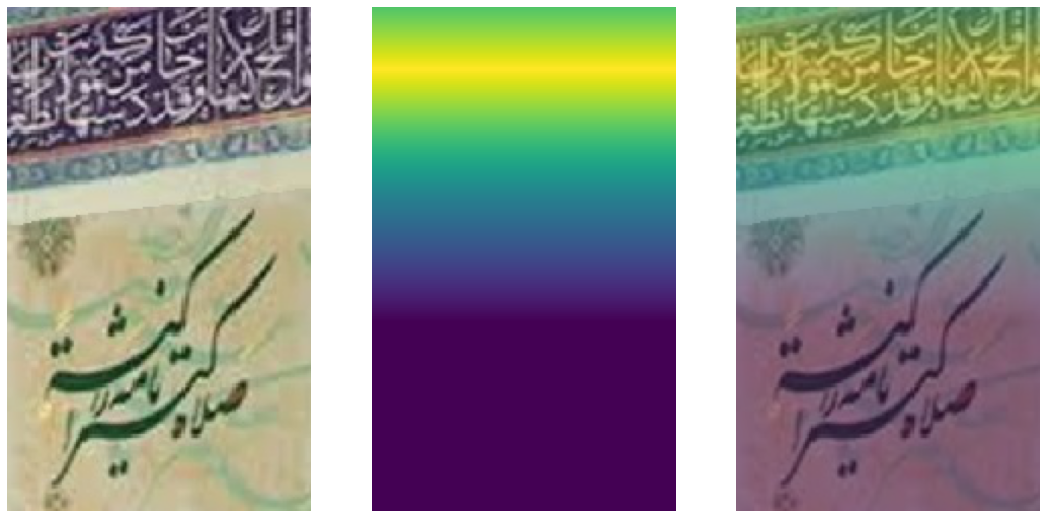

In [46]:
map = yHat[0][:,:,0]
print(map.shape)
map = resize(map, (x.shape[0], x.shape[1]))

fig, ax = plt.subplots(1,3)
fig.set_size_inches(18.5, 10.5)
ax[0].imshow(x)
ax[0].axis('off')
ax[1].imshow(map)
ax[1].axis('off')
ax[2].imshow(x)
ax[2].imshow(map, alpha=0.5)
ax[2].axis('off')
plt.show()
fig.savefig('output_divar2_crop.jpg', dpi=100)


In [47]:
# تست یک تصویر شامل چندین نمونه 
fileName = 'data/baz-in-che-shoresh-ast.jpg' 
img = image.load_img(fileName,color_mode='rgb')
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.
# print(file,img_tensor.shape)
x = img_tensor[0]
imSize = [x.shape[0],x.shape[1]]

tmp = [s/inputImSize for s in imSize]
if min(tmp)<1:
    scale = 1/min(tmp)  
    newH = int(math.ceil(scale * imSize[0]))
    newW = int(math.ceil(scale * imSize[1]))
    img = image.load_img(fileName,color_mode='rgb',target_size=(newH,newW))
    img_tensor = image.img_to_array(img)
    img_tensor = np.expand_dims(img_tensor, axis=0)
    img_tensor /= 255.
    x = img_tensor[0]
    imSize = [x.shape[0],x.shape[1]]

convModel = FC2FC.convert_model(model,mdl,imSize)

yHat = convModel.predict(img_tensor)

(11, 77)


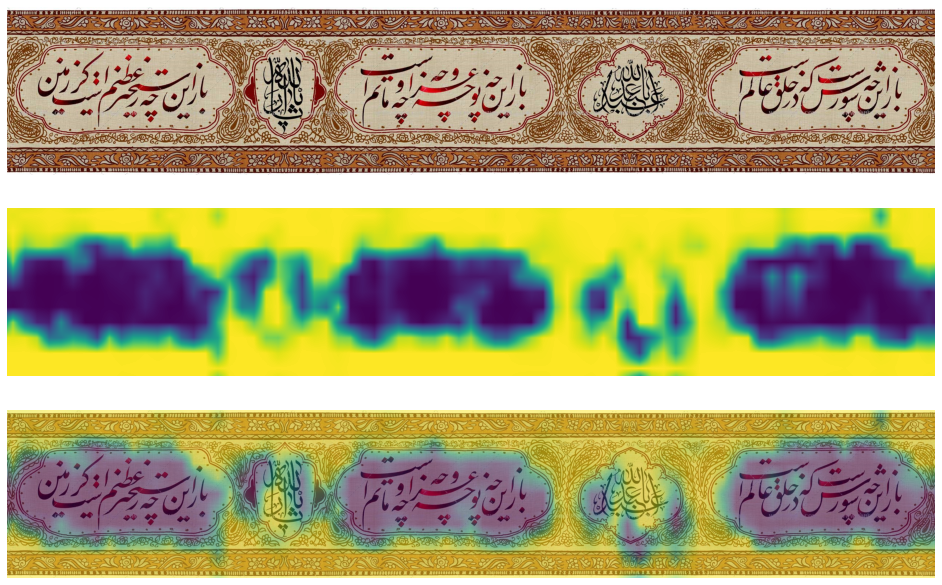

In [48]:
map = yHat[0][:,:,0]
print(map.shape)
map = resize(map, (x.shape[0], x.shape[1]))

fig, ax = plt.subplots(3,1)
fig.set_size_inches(18.5, 10.5)
ax[0].imshow(x)
ax[0].axis('off')
ax[1].imshow(map)
ax[1].axis('off')
ax[2].imshow(x)
ax[2].imshow(map, alpha=0.5)
ax[2].axis('off')
plt.show()
fig.savefig('output_baz-in-che-shoresh-ast.jpg', dpi=100)